<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/Ahmed-resnet50/classification-Models/Original_Dataset_Models/oranges_classification_original_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
from google.colab import drive
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

!pip install keras-cv
import keras_cv

In [ ]:
import pandas as pd
drive.mount('/content/drive', force_remount=True)
train_ds = '/content/drive/MyDrive/new_dataset/original_Dataset/train'
test_ds = '/content/drive/MyDrive/new_dataset/original_Dataset/test'
img_height, img_width = 224, 224
batch_size = 32
epochs = 50


Mounted at /content/drive


In [ ]:
categories = os.listdir(train_ds)
nums = {}
for lebal in categories:
    nums[lebal] = len(os.listdir(os.path.join(train_ds, lebal)))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
rotten,748
healthy,740


In [ ]:
categories = os.listdir(test_ds)
nums = {}
for lebal in categories:
    nums[lebal] = len(os.listdir(os.path.join(test_ds, lebal)))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
rotten,188
healthy,185


Found 1488 files belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 383s 9s/step - accuracy: 0.8496 - loss: 5.2988 - val_accuracy: 0.9861 - val_loss: 2.8620
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 337s 9s/step - accuracy: 0.9634 - loss: 2.4410 - val_accuracy: 0.9653 - val_loss: 1.4577
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 332s 9s/step - accuracy: 0.9713 - loss: 1.3357 - val_accuracy: 0.9792 - val_loss: 1.0086
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 331s 8s/step - accuracy: 0.9755 - loss: 0.9396 - val_accuracy: 0.9826 - val_loss: 0.7132
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 345s 9s/step - accuracy: 0.9841 - loss: 0.6508 - val_accuracy: 0.9306 - val_loss: 0.7136
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 363s 8s/step - accuracy: 0.9709 - loss: 0.6401 - val_accuracy: 0.9861 - val_loss: 0.5926
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 330s 8s/step - accuracy: 0.9830 - loss: 0.5588 - val_accuracy: 0.9861 - val_loss: 0.5081
Epoch 8/50
38/38 ━━

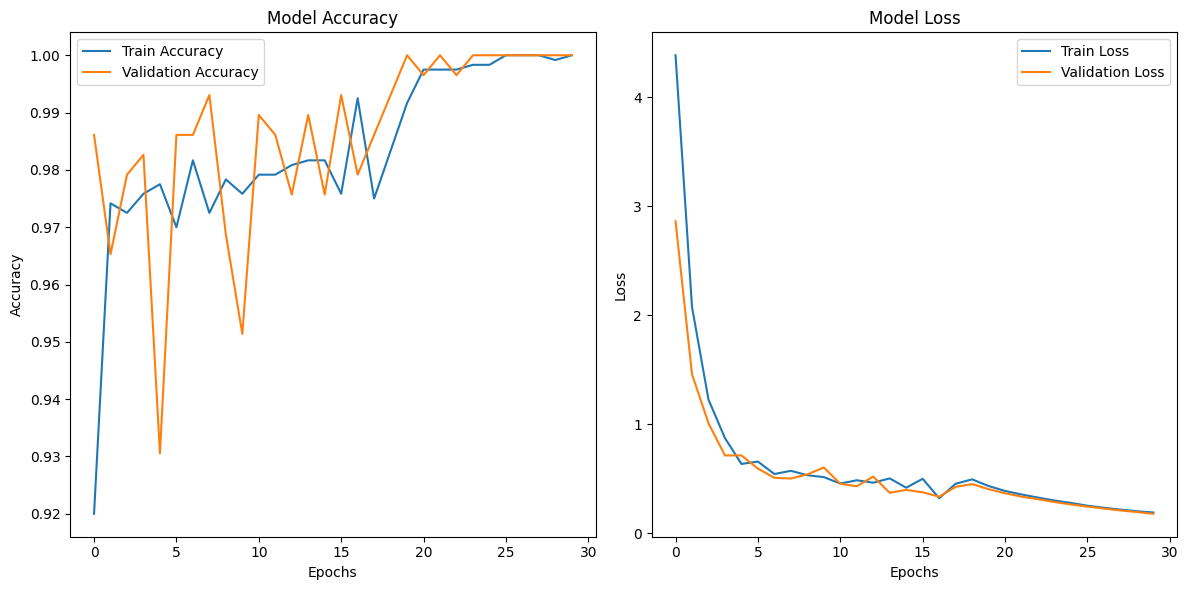

In [ ]:
def load_and_split_data(train_dir):
    # Load the dataset from the directory
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )

    # Split into training and validation datasets
    total_batches = tf.data.experimental.cardinality(dataset).numpy()
    val_size = int(total_batches * 0.2)

    val_ds = dataset.take(val_size)
    train_ds = dataset.skip(val_size)

    # Prefetch to improve performance
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds


# Function to create the model
def create_model():
    # Load ResNet50 base model with pretrained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze base model

    # Build the model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(384, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        layers.BatchNormalization(),  # Batch normalization
        layers.Dropout(0.4),
        layers.Dense(2, activation='softmax')  # 2 output classes
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Initial learning rate
        loss='sparse_categorical_crossentropy',  # Suitable for binary labels
        metrics=['accuracy']
    )

    return model


# Train the model
def train_model(model, train_ds, val_ds):
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    # Initial training with frozen base model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping]
    )

    return history


# Fine-tune the model
def fine_tune_model(model, train_ds, val_ds, base_model):
    # Unfreeze the last 10 layers of the base model
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Recompile the model with a smaller learning rate
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    # Fine-tuning
    fine_tune_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping]
    )

    return fine_tune_history


# Plot accuracy and loss
def plot_training(history, fine_tune_history):
    # Combine histories
    full_history = {
        'accuracy': history.history['accuracy'] + fine_tune_history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
        'loss': history.history['loss'] + fine_tune_history.history['loss'],
        'val_loss': history.history['val_loss'] + fine_tune_history.history['val_loss']
    }

    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Main script
if __name__ == "__main__":
    train_dir = "path_to_train_directory"  # Replace with your training data path

    # Load and split the data
    train_ds, val_ds = load_and_split_data(train_ds)

    # Create the model
    model = create_model()
    base_model = model.layers[0]  # Extract the base model for fine-tuning

    # Train the model
    history = train_model(model, train_ds, val_ds)

    # Fine-tune the model
    fine_tune_history = fine_tune_model(model, train_ds, val_ds, base_model)

    # Plot the training results
    plot_training(history, fine_tune_history)

    # Save the model
    model.save("fresh_vs_rotten_oranges_final_result.keras")

Found 373 files belonging to 2 classes.
Confusion Matrix:
[[184   1]
 [  4 184]]


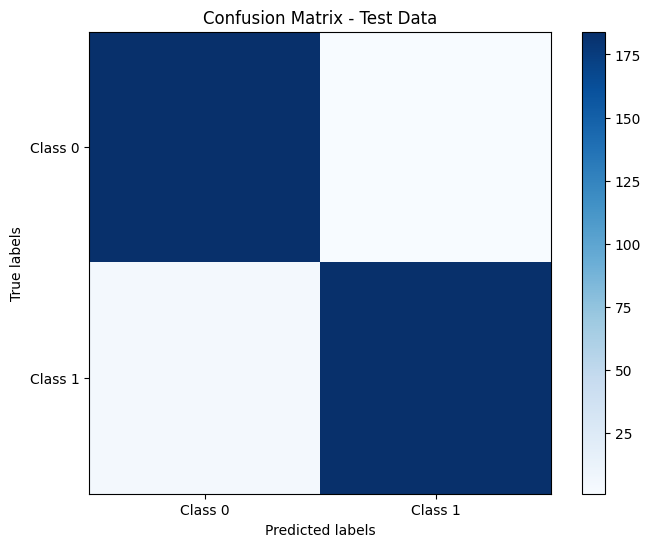

Accuracy: 0.9866
Precision: 0.9946
Recall: 0.9787
F1-Score: 0.9866


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Step 1: Load your test dataset
# Assuming you've already split your data into 'train_ds', 'val_ds', and 'test_ds'
# You can load your test data similarly to how you loaded the validation data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,  # Replace with your test directory
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'  # or 'int' depending on your number of classes
)

# Step 2: Make Predictions on the Test Set
y_true = []
y_pred = []

# Loop through the test dataset and collect true labels and predictions
for images, labels in test_ds:
    # Store the true labels
    y_true.extend(labels.numpy())

    # Predict the classes (output of the model)
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))  # Get the class with the highest probability

# Step 3: Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Print the Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.colorbar()
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])  # Adjust for the number of classes
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])  # Adjust for the number of classes
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Step 5: Calculate and Print Performance Metrics (Optional)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


In [ ]:
final_train_acc = fine_tune_history.history['accuracy'][-1]
final_val_acc = fine_tune_history.history['val_accuracy'][-1]
final_train_loss = fine_tune_history.history['loss'][-1]
final_val_loss = fine_tune_history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
Final Training Loss: 0.1897
Final Validation Loss: 0.1780


In [ ]:
print(f"Training stopped at epoch: {len(fine_tune_history.history['loss'])}")


Training stopped at epoch: 12
